#  LangGraph Parallel Workflow Example: Banking Domain

This hands-on example on **Parallel workflow** using **LangGraph** in the **Banking domain**.

---

##  Objective

Given a customer banking query, the system will process it in **parallel** to:

- 📄 **Classify the query type**  
  *(e.g., Loan, Account, Credit Card, Fraud, General Inquiry)*

- 💬 **Generate a professional response draft**

- 📊 **Assess the urgency level**  
  *(e.g., High, Medium, Low)*

Once all tasks are completed, their results are **combined into a structured report**.

---

##  Key Concepts Covered

- Parallel prompt execution (fan-out)
- Result aggregation (fan-in)
- State management with `TypedDict`
- Multi-node LangGraph workflows using `StateGraph`
- Use of `ChatOpenAI` for LLM-powered classification, summarization, and generation

---


### LangGraph Workflow Diagram – Banking Query (Parallel Workflow)

```mermaid
graph TD
    START((Start)) --> Classify[Classify Query Type]
    START --> Urgency[Assess Urgency]
    START --> Respond[Generate Response]
    Classify --> Report[Compile Report]
    Urgency --> Report
    Respond --> Report
    Report --> END((End))


In [ ]:
#!pip install langchain langchain_openai langgraph typing_extensions -q

In [1]:
from typing import TypedDict, List
from typing_extensions import Annotated
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
import os
import operator

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-proj-xxxxxxxxxxxxx"

In [3]:
# Set up model
model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

In [ ]:
# ---------- State Definition ----------
class State(TypedDict):
    query: str
    #Annotated with operator.add means this field can be updated by multiple nodes
    category: Annotated[str, operator.add]
    urgency: Annotated[str, operator.add]
    response: Annotated[str, operator.add]
    report: str

In [4]:
# ---------- State Definition ----------
class State(TypedDict):
    query: str
    category: str
    urgency: str
    response: str
    report: str

Note : use Annotated  to tell LangGraph that This field (query) is input-only, don’t treat it as being updated in the workflow.

In [5]:
# ---------- Node Functions ----------
def classify_query(state: State):
    prompt = f"Classify: {state['query']}. Categories: Loan, Account, Credit Card, Fraud, General Inquiry. Return only category."
    return {"category": model.invoke(prompt).content.strip()} # partial update state variable


In [6]:
def assess_urgency(state: State):
    prompt = f"Assess urgency: {state['query']}. Options: High, Medium, Low. Return only urgency."
    return {"urgency": model.invoke(prompt).content.strip()} # partial update state variable

In [7]:
def generate_response(state: State):
    prompt = f"Write response to: {state['query']}. Keep it professional and concise."
    return {"response": model.invoke(prompt).content.strip()} # partial update state variable

In [8]:
def compile_report(state: State):
    report = f"""
    === Customer Query Report ===
    Query: {state['query']}
    Category: {state.get('category', 'N/A')}
    Urgency: {state.get('urgency', 'N/A')}
    Response: {state.get('response', 'N/A')}
    """
    return {"report": report} # partial update state variable

In [9]:
# Build graph
builder = StateGraph(State)

builder.add_node("classify", classify_query)
builder.add_node("urgency", assess_urgency)
builder.add_node("response", generate_response)
builder.add_node("report", compile_report)

builder.add_edge(START, "classify")
builder.add_edge(START, "urgency")
builder.add_edge(START, "response")

builder.add_edge("classify", "report")
builder.add_edge("urgency", "report")
builder.add_edge("response", "report")

builder.add_edge("report", END)

In [10]:
workflow = builder.compile()

In [11]:
# Execute
result = workflow.invoke({
    "query": "I want to apply for a home loan. What documents do I need?"
})

Sample Query:

- I want to apply for a home loan. What documents do I need?
- There are two unauthorized transactions on my credit card. Please investigate!
- Can you help me activate net banking for my savings account?


In [12]:
print(result["report"])



    === Customer Query Report ===
    Query: I want to apply for a home loan. What documents do I need?
    Category: Loan
    Urgency: High
    Response: Thank you for your interest in applying for a home loan. In order to proceed with your application, you will need to provide the following documents:

1. Proof of identification (e.g. driver's license, passport)
2. Proof of income (e.g. pay stubs, tax returns)
3. Bank statements
4. Employment verification
5. Credit report

Please gather these documents and reach out to our loan officer to begin the application process. Thank you.
    


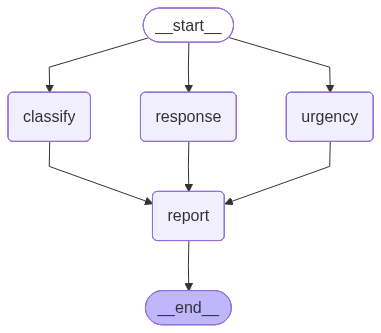

In [13]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())